---

# **Imports**

In [2]:
import numpy as np
from scipy.stats import norm
import ot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, lognorm

---

# **General Functions**

In [2]:
def c(x, y, K):
    return np.maximum(y - K, 0) - x

def uniform_support(a, b, n):
    return np.linspace(a, b, n)

def cost_matrix(xi, yj, K):
    return c(xi[:, None], yj, K)

def project_onto_C1(p, mu):
    return p * (mu / (p.sum(axis=1) + 1e-8))

def project_onto_C2(p, nu):
    return p * (nu / (p.sum(axis=0) + 1e-8))

def project_onto_martingale_constraint(p, xi, yj, mu):
    expected_y_per_x = np.dot(p, yj) / (mu + 1e-8)
    adjustment_factors = xi / expected_y_per_x
    adjustment_factors = np.where(np.isnan(adjustment_factors), 1, adjustment_factors)
    p_adjusted = p * adjustment_factors[:, None]
    return p_adjusted

def bregman_projection(mu, nu, xi, yj, C, max_iter=100):
    m, n = C.shape
    p = np.exp(-C)
    p /= np.sum(p)
    for _ in range(max_iter):
        p = project_onto_C1(p, mu)
        p = project_onto_C2(p, nu)
        p = project_onto_martingale_constraint(p, xi, yj, mu)
        p /= np.sum(p)
    return p

def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

---

# **Calculation with basic Black Scholes method**

In [3]:
# Parameters for the European call option
S = 100  # Initial stock price
K = 100  # Strike price
T = 1    # Time to maturity (in years)
r = 0.05 # Risk-free interest rate
sigma = 0.2  # Volatility

# Classic method: Black-Scholes pricing
classic_price = black_scholes_call(S, K, T, r, sigma)
print("Classic method (Black-Scholes) price:", classic_price)

Classic method (Black-Scholes) price: 10.450583572185565


---

# **Calculation with Monte Carlo Simulations**

In [3]:
S = 100  # Initial stock price
K = 100  # Strike price
T = 1    # Time to maturity (in years)
r = 0.05 # Risk-free interest rate
sigma = 0.2  # Volatility
n_trials = 10000  # Number of Monte Carlo trials
dt = 1/252  # Time step in years, assuming 252 trading days per year
n_steps = int(T / dt)  # Number of steps within the time to maturity

# Initializing the array for storing simulated end-of-period prices
price_paths = np.zeros((n_steps + 1, n_trials))
price_paths[0] = S

# Simulating price paths
for t in range(1, n_steps + 1):
    Z = np.random.standard_normal(n_trials)  # Generate random shocks
    price_paths[t] = price_paths[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Calculating the payoffs for a call option at maturity
payoffs = np.maximum(price_paths[-1] - K, 0)

# Discounting the payoffs to present value
monte_carlo_price = np.exp(-r * T) * np.mean(payoffs)

print("Monte Carlo simulation price with Brownian motion:", monte_carlo_price)

Monte Carlo simulation price with Brownian motion: 10.668063286564573


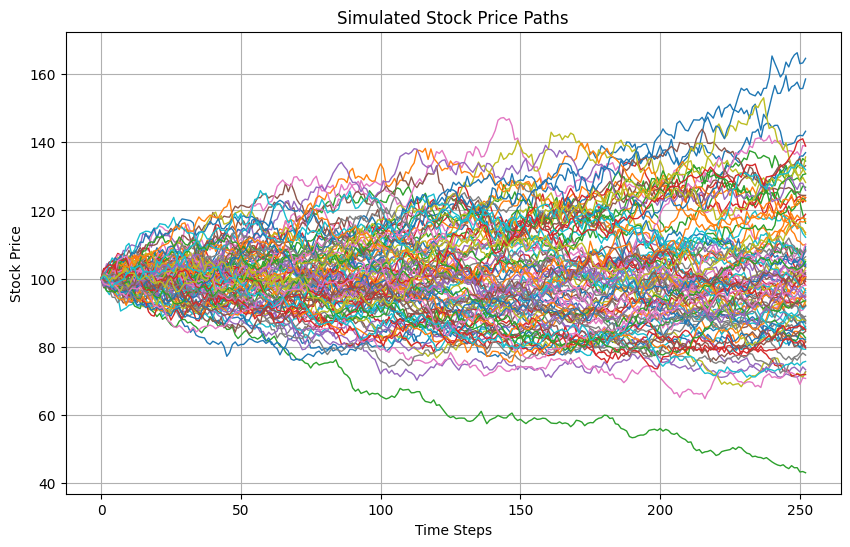

In [7]:
# Simulating price paths for plotting
n_plot_trials = 100  # We Reduced number of trials for a clearer plot
price_paths_plot = np.zeros((n_steps + 1, n_plot_trials))
price_paths_plot[0] = S

for t in range(1, n_steps + 1):
    Z = np.random.standard_normal(n_plot_trials)  # Generate random shocks for plotting
    price_paths_plot[t] = price_paths_plot[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

# Plotting some of the simulated stock price paths
plt.figure(figsize=(10, 6))
for i in range(n_plot_trials):
    plt.plot(price_paths_plot[:, i], lw=1)

plt.title('Simulated Stock Price Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.grid(True)
plt.show()

---

# **Calculation with our Bregman Projection method**

In [4]:
n = 100  # Number of support points for each distribution
xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
C = cost_matrix(xi, yj, K)
mu = stats.lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
mu /= np.sum(mu)
nu = stats.lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
nu /= np.sum(nu)

p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
payoff_matrix = np.maximum(yj - K, 0)
bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)
print("Bregman projection price:", bregman_price)

Bregman projection price: 11.777874928683802


---

# **Calculation with the Sinkhorn-Knopp algorithm**

In [5]:
# Discretization
n_bins = 100
x_bins = np.linspace(0, 2*S, n_bins+1)
y_bins = np.linspace(0, 2*S, n_bins+1)

# Compute the initial and final distributions
mu_hist = lognorm.pdf(x_bins[:-1], s=sigma * np.sqrt(T), scale=S)
mu_hist /= np.sum(mu_hist)
nu_hist = lognorm.pdf(y_bins[:-1], s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
nu_hist /= np.sum(nu_hist)

# Compute the cost matrix
x_centers = (x_bins[:-1] + x_bins[1:]) / 2
y_centers = (y_bins[:-1] + y_bins[1:]) / 2
cost_matrix_var = np.maximum(y_centers.reshape(-1, 1) - K, 0) - x_centers.reshape(1, -1)

# Define the martingale constraint matrix
martingale_matrix = x_centers.reshape(-1, 1) - y_centers.reshape(1, -1)

# Solve the MOT problem using the Sinkhorn-Knopp algorithm with martingale constraints
reg_epsilon = 0.01
transport_plan = ot.sinkhorn(mu_hist, nu_hist, cost_matrix_var, reg_epsilon, m=martingale_matrix)

# Compute the option price using the optimal transport plan
payoff_matrix = np.maximum(y_centers - K, 0)
sinkhorn_price = np.exp(-r * T) * np.sum(transport_plan * payoff_matrix)
print("Sinkhorn-Knopp price:", sinkhorn_price)

Sinkhorn-Knopp price: nan


d:\anaconda\envs\CS_LabProject\Lib\site-packages\ot\backend.py:1140: RuntimeWarning: overflow encountered in exp
  return np.exp(a)
d:\anaconda\envs\CS_LabProject\Lib\site-packages\ot\bregman\_sinkhorn.py:491: RuntimeWarning: divide by zero encountered in divide
  Kp = (1 / a).reshape(-1, 1) * K
d:\anaconda\envs\CS_LabProject\Lib\site-packages\ot\bregman\_sinkhorn.py:491: RuntimeWarning: overflow encountered in multiply
  Kp = (1 / a).reshape(-1, 1) * K
d:\anaconda\envs\CS_LabProject\Lib\site-packages\ot\bregman\_sinkhorn.py:506: UserWarning: Warning: numerical errors at iteration 0
  warnings.warn('Warning: numerical errors at iteration %d' % ii)
C:\Users\monde\AppData\Local\Temp\ipykernel_31180\758836247.py:26: RuntimeWarning: invalid value encountered in multiply
  sinkhorn_price = np.exp(-r * T) * np.sum(transport_plan * payoff_matrix)


Here the final Sinkhorn-Knopp price is equal to nans because we got a lot of nans in the final transport plan it self.

Numerical instability: The Sinkhorn algorithm involves exponentiating the cost matrix and performing element-wise division. If the cost matrix contains very large or very small values, or if the regularization parameter reg_epsilon is too small, it can lead to numerical instability and produce NaNs in the transport plan.

Incompatible marginals: The Sinkhorn algorithm assumes that the input marginals (mu_hist and nu_hist) are valid probability distributions that sum up to 1. If the marginals are not properly normalized or if they have incompatible shapes, it can cause issues in the algorithm and result in NaNs.

Insufficient regularization: The regularization parameter reg_epsilon plays a crucial role in the convergence and stability of the Sinkhorn algorithm. If the regularization is insufficient (i.e., reg_epsilon is too small), it can lead to numerical issues and produce NaNs in the transport plan.

---

# **Sensitivity Analysis**

Compare the Black-Scholes model and our new Bregman Projection method.

In [6]:
# Parameters for the European call option
S = 100  # Initial stock price
K = 100  # Strike price
T = 1    # Time to maturity (in years)
r = 0.05 # Risk-free interest rate
sigma = 0.2  # Volatility

n = 100  # Number of support points for each distribution

Evaluate the sensitivity to change in initial stock price

In [7]:
# Sensitivity analysis for strike price
initial_prices = np.linspace(80, 120, 50)
classic_prices_initial = []
bregman_prices_initial = []
for S in initial_prices:
    classic_price = black_scholes_call(S, K, T, r, sigma)
    classic_prices_initial.append(classic_price)
    
    xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    C = cost_matrix(xi, yj, K)
    mu = lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    mu /= np.sum(mu)
    nu = lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    nu /= np.sum(nu)
    p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
    payoff_matrix = np.maximum(yj - K, 0)
    bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)
    bregman_prices_initial.append(bregman_price)

Evaluate the sensitivity to change in strike prices

In [8]:
# Reset stock price
S = 100  # Initial stock price

In [9]:
# Sensitivity analysis for strike price
strike_prices = np.linspace(80, 120, 50)
classic_prices_strike = []
bregman_prices_strike = []
for K in strike_prices:
    classic_price = black_scholes_call(S, K, T, r, sigma)
    classic_prices_strike.append(classic_price)
    
    xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    C = cost_matrix(xi, yj, K)
    mu = lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    mu /= np.sum(mu)
    nu = lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    nu /= np.sum(nu)
    p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
    payoff_matrix = np.maximum(yj - K, 0)
    bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)
    bregman_prices_strike.append(bregman_price)

Evaluate the sensitivity to change in maturity

In [10]:
# Reset strike price
K = 100  # Strike price

In [11]:
# Sensitivity analysis for time to maturity
maturities = np.linspace(0.5, 2, 50)
classic_prices_maturity = []
bregman_prices_maturity = []
for T in maturities:
    classic_price = black_scholes_call(S, K, T, r, sigma)
    classic_prices_maturity.append(classic_price)
    
    xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    C = cost_matrix(xi, yj, K)
    mu = lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    mu /= np.sum(mu)
    nu = lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    nu /= np.sum(nu)
    p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
    payoff_matrix = np.maximum(yj - K, 0)
    bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)
    bregman_prices_maturity.append(bregman_price)

Evaluate the sensitivity to change in interest rate

In [12]:
# Reset TTM
T = 1    # Time to maturity (in years)

In [13]:
# Sensitivity analysis for risk-free interest rate
interest_rates = np.linspace(0.01, 0.1, 50)
classic_prices_interest = []
bregman_prices_interest = []
for r in interest_rates:
    classic_price = black_scholes_call(S, K, T, r, sigma)
    classic_prices_interest.append(classic_price)
    
    xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    C = cost_matrix(xi, yj, K)
    mu = lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    mu /= np.sum(mu)
    nu = lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    nu /= np.sum(nu)
    p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
    payoff_matrix = np.maximum(yj - K, 0)
    bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)
    bregman_prices_interest.append(bregman_price)

Evaluate the sensitivity to change in volatility

In [14]:
# Reset risk-free
r = 0.05 # Risk-free interest rate

In [18]:
# Sensitivity analysis for risk-free interest rate
volatilities = np.linspace(0.2, 0.5, 50)
classic_prices_vol = []
bregman_prices_vol = []
for sigma in volatilities:
    classic_price = black_scholes_call(S, K, T, r, sigma)
    classic_prices_vol.append(classic_price)
    
    xi = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    yj = uniform_support(S * np.exp(-5 * sigma * np.sqrt(T)), S * np.exp(5 * sigma * np.sqrt(T)), n)
    C = cost_matrix(xi, yj, K)
    mu = lognorm.pdf(xi, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    mu /= np.sum(mu)
    nu = lognorm.pdf(yj, s=sigma * np.sqrt(T), scale=S * np.exp(r * T))
    nu /= np.sum(nu)
    p_star_bregman = bregman_projection(mu, nu, xi, yj, C)
    payoff_matrix = np.maximum(yj - K, 0)
    bregman_price = np.exp(-r * T) * np.sum(p_star_bregman * payoff_matrix)
    bregman_prices_vol.append(bregman_price)

C:\Users\monde\AppData\Local\Temp\ipykernel_31180\1722906215.py:25: RuntimeWarning: overflow encountered in exp
  p = np.exp(-C)
C:\Users\monde\AppData\Local\Temp\ipykernel_31180\1722906215.py:26: RuntimeWarning: invalid value encountered in divide
  p /= np.sum(p)


### **Visualization of our sensitivity analysis**

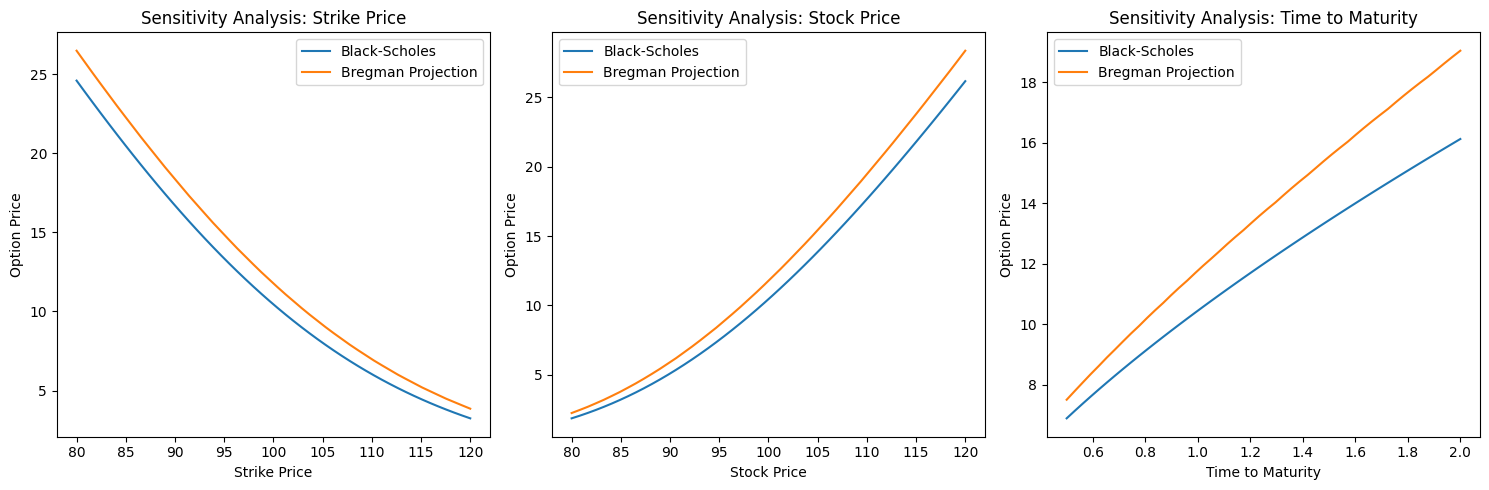

In [19]:
# Stock Price, Strike Price and Maturity
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[1].plot(initial_prices, classic_prices_initial, label='Black-Scholes')
axs[1].plot(initial_prices, bregman_prices_initial, label='Bregman Projection')
axs[1].set_xlabel('Stock Price')
axs[1].set_ylabel('Option Price')
axs[1].set_title('Sensitivity Analysis: Stock Price')
axs[1].legend()

axs[0].plot(strike_prices, classic_prices_strike, label='Black-Scholes')
axs[0].plot(strike_prices, bregman_prices_strike, label='Bregman Projection')
axs[0].set_xlabel('Strike Price')
axs[0].set_ylabel('Option Price')
axs[0].set_title('Sensitivity Analysis: Strike Price')
axs[0].legend()

axs[2].plot(maturities, classic_prices_maturity, label='Black-Scholes')
axs[2].plot(maturities, bregman_prices_maturity, label='Bregman Projection')
axs[2].set_xlabel('Time to Maturity')
axs[2].set_ylabel('Option Price')
axs[2].set_title('Sensitivity Analysis: Time to Maturity')
axs[2].legend()

plt.tight_layout()
plt.show()

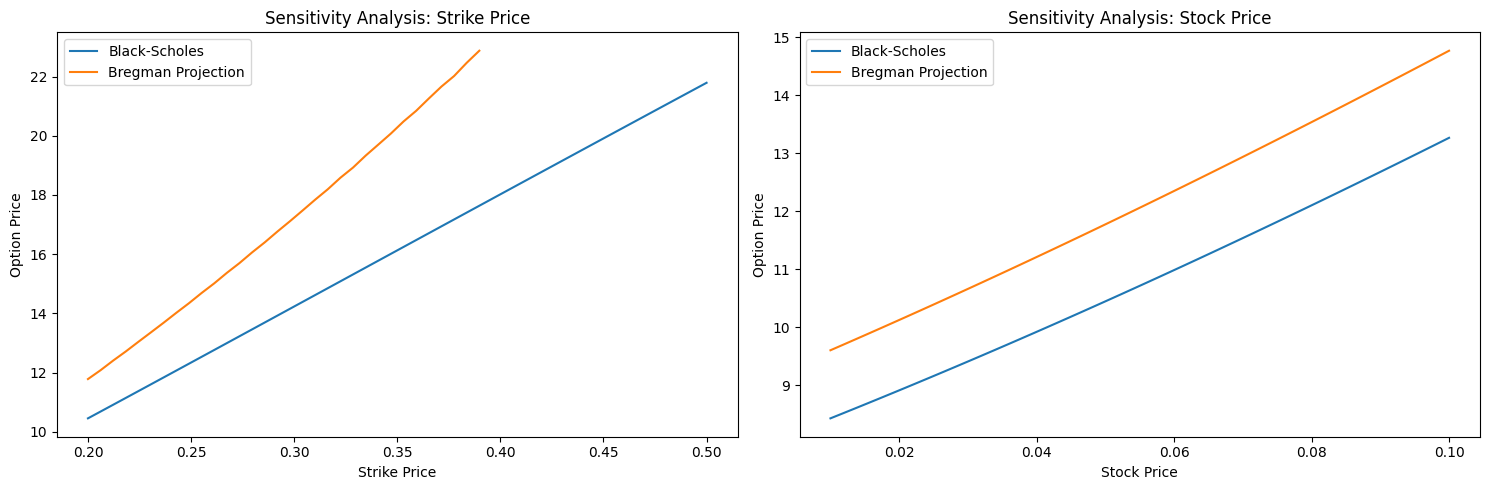

In [20]:
# Stock Price, Strike Price and Maturity
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[1].plot(interest_rates, classic_prices_interest, label='Black-Scholes')
axs[1].plot(interest_rates, bregman_prices_interest, label='Bregman Projection')
axs[1].set_xlabel('Stock Price')
axs[1].set_ylabel('Option Price')
axs[1].set_title('Sensitivity Analysis: Stock Price')
axs[1].legend()

axs[0].plot(volatilities, classic_prices_vol, label='Black-Scholes')
axs[0].plot(volatilities, bregman_prices_vol, label='Bregman Projection')
axs[0].set_xlabel('Strike Price')
axs[0].set_ylabel('Option Price')
axs[0].set_title('Sensitivity Analysis: Strike Price')
axs[0].legend()

plt.tight_layout()
plt.show()

Our bregman projection overprice a little bit the classic price but give consistent and logic results.

### **Numerical error analysis**

In [26]:
# Fix NaNs value in the volatility
bregman_prices_vol = [value for value in bregman_prices_vol if not np.isnan(value)]
classic_prices_vol = classic_prices_vol[:len(bregman_prices_vol)] 

In [27]:
# Calculate and print the numerical error
error_stock = np.mean(np.abs(np.array(classic_prices_initial) - np.array(bregman_prices_initial)) / np.array(classic_prices_initial))
error_strike = np.mean(np.abs(np.array(classic_prices_strike) - np.array(bregman_prices_strike)) / np.array(classic_prices_strike))
error_maturity = np.mean(np.abs(np.array(classic_prices_maturity) - np.array(bregman_prices_maturity)) / np.array(classic_prices_maturity))
error_interest = np.mean(np.abs(np.array(classic_prices_interest) - np.array(bregman_prices_interest)) / np.array(classic_prices_interest))
error_vol = np.mean(np.abs(np.array(classic_prices_vol) - np.array(bregman_prices_vol)) / np.array(classic_prices_vol))

In [28]:
print(f"Numerical error (stock price): {error_stock:.2%}")
print(f"Numerical error (strike price): {error_strike:.2%}")
print(f"Numerical error (time to maturity): {error_maturity:.2%}")
print(f"Numerical error (Interest rates): {error_interest:.2%}")
print(f"Numerical error (Volatility): {error_vol:.2%}")

Numerical error (stock price): 13.30%
Numerical error (strike price): 12.89%
Numerical error (time to maturity): 13.96%
Numerical error (Interest rates): 12.58%
Numerical error (Volatility): 20.82%
